In [11]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import mlflow
import dagshub
import json
import shutil
import matplotlib.pyplot as plt
from dagshub import dagshub_logger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import confusion_matrix, classification_report
from kerastuner.tuners import RandomSearch

In [12]:
# MLflow - Dagshub initialization
mlflow.set_tracking_uri("https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow")

dagshub.init(repo_owner='alfoCaiazza', repo_name='FingerSpellIT', mlflow=True)
dagshub_log = dagshub_logger(metrics_path="metrics", hparams_path="params")

Initialized MLflow to track repo "alfoCaiazza/FingerSpellIT"

Repository alfoCaiazza/FingerSpellIT initialized!

In [13]:
# To avoid OOM errors, setting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(f"GPU: {gpu}")
    tf.config.experimental.set_memory_growth(gpu, True) # Keeping the use of memory limited to prevent errors

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
train_dir = '../data/processed/train'
val_dir = '../data/processed/val'
test_dir = '../data/processed/test'

# Automatically creates a dataset form the referred directory. Load the full dataset, shuffle = True ensures randomness
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123
)

class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123
)

Found 4489 files belonging to 22 classes.
Found 962 files belonging to 22 classes.
Found 977 files belonging to 22 classes.


In [15]:
# Pre-processing sequential model
preprocessing_model = tf.keras.Sequential([
    # Normalizing the images for ResNet50 model (0,1)
    tf.keras.layers.Rescaling(1./255), 

    # # Data augmentation:
    # tf.keras.layers.RandomFlip("horizontal"),  # Simulating left hand
    # tf.keras.layers.RandomRotation(0.1),       # Rotations, max ±10%

    # # Gaussiano noise
    # tf.keras.layers.Lambda(
    #     lambda x: tf.clip_by_value(
    #         x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.05), 0.0, 1.0
    #     )
    # ),

    # tf.keras.layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (preprocessing_model(x), y))
val_ds = val_ds.map(lambda x, y: (preprocessing_model(x), y))
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

In [16]:
# Handling data batch size automatically 
AUTOTUNE = tf.data.AUTOTUNE

train_ds= train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds= val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
# Importing net for transfer learning
def build_model(hp):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False, # Excludes the first layer
        input_shape=(224,224, 3) # Specifing input shape
    )

    # Freezing net layers
    base_model.trainable = False

    # Adding more layer to the net from its output and adapting it to a multi-class classification task 
    x = GlobalAveragePooling2D()(base_model.output)
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])
    x = Dense(hp.Int('units', 128, 512, step=128), activation=activation)(x)
    predictions = Dense(22, activation='softmax')(x) 

    # Creiamo il modello finale
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiliamo il modello
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [18]:
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

# Customized Callback for tracking single trial parmas with MLflow
class MLflowCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial_hyperparameters, trial_id):
        super().__init__()
        self.trial_id = trial_id
        self.trial_hyperparameters = trial_hyperparameters

    # Create a nested mlrun to register the trial
    def on_train_begin(self, logs=None):
        self.run = mlflow.start_run(run_name=f"trial_{self.trial_id}", nested=True)
        
        # Tracks oll trial params
        mlflow.log_param('trial_id', self.trial_id)
        for param_name, param_value in self.trial_hyperparameters.values.items():
            mlflow.log_param(param_name, param_value)

    # Tracks all trial metrics
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for metric_name, value in logs.items():
                mlflow.log_metric(metric_name, value, step=epoch)

    # Close the mlrun 
    def on_train_end(self, logs=None):
        if self.run:
            mlflow.end_run()

In [19]:
# Subclassed RandomSerach tuner which uses customized MLflow callback
class MLflowTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        callbacks = callbacks_base + [MLflowCallback(trial.hyperparameters, trial.trial_id)]
        kwargs['callbacks'] = callbacks
        return super().run_trial(trial, *args, **kwargs)

In [ ]:
with mlflow.start_run(run_name="Main Tunining Run"):
    epochs = 50
    mlflow.log_param('epochs', epochs)

    tuner = MLflowTuner(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory='tuner_logs',
        project_name='FingerSpellIT optimization'
    )
    
    tuner.search(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

    for param, value in best_hps.values.items():
        mlflow.log_param(param, value)

    # Log metriche finali del trial
    for metric_name, metric_data in best_trial.metrics.metrics.items():
        if metric_data and isinstance(metric_data, dict):
            values = metric_data.get('value', [])
            if values:
                mlflow.log_metric(metric_name, values[-1])

    # Salving the model
    model_path = "../model/model_fingerspelling_v1.h5"
    best_model.save(model_path)
    mlflow.log_artifact(model_path)

Trial 5 Complete [00h 14m 43s]
val_accuracy: 0.7869023084640503

Best val_accuracy So Far: 0.7869023084640503
Total elapsed time: 01h 07m 56s


/home/acaia/LIS/LIS-Gesture-Translator/.lis/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🏃 View run Main Tunining Run at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0/runs/6f09ef06b1d34757b03f4eff8ffe7d03
🧪 View experiment at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0


FileNotFoundError: [Errno 2] No such file or directory: 'trial_models'

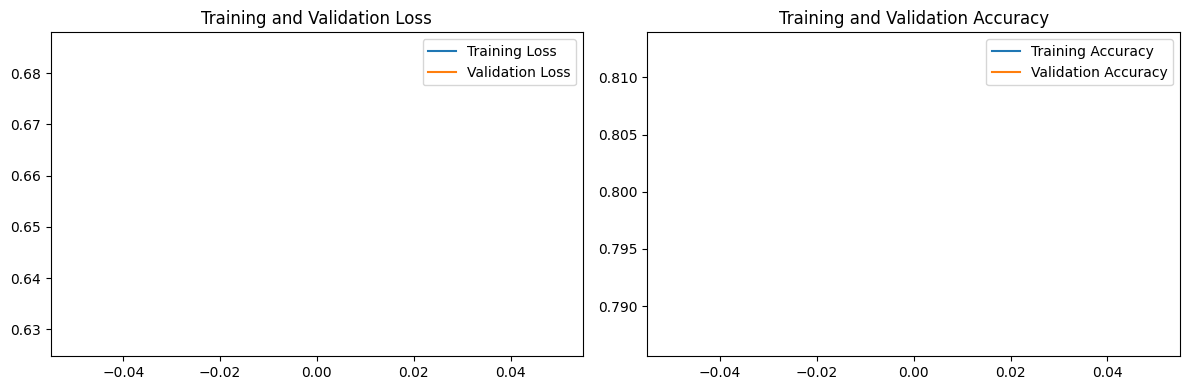

In [32]:
# Converte in liste ordinate per plotting
def extract_metric(metric_history):
    return [step.value for step in metric_history]


# Estrai l'elenco degli step e valori di metriche
train_loss = best_trial.metrics.get_history('loss')
val_loss = best_trial.metrics.get_history('val_loss')
train_acc = best_trial.metrics.get_history('accuracy')
val_acc = best_trial.metrics.get_history('val_accuracy')

loss_values = extract_metric(train_loss)
val_loss_values = extract_metric(val_loss)
acc_values = extract_metric(train_acc)
val_acc_values = extract_metric(val_acc)

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [33]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Evaluation accuracy: {test_acc:.3f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(best_model.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2025-05-14 23:09:59.037325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.7815 - loss: 0.6941
Evaluation accuracy: 0.768


2025-05-14 23:10:02.279903: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-14 23:10:16.552735: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
report_path = '../model/artifacts/classification_report.json'
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(report)
with open(report_path, "w") as f:
    json.dump(report, f, indent=4)

mlflow.log_artifact(report_path)

{'a': {'precision': 0.875, 'recall': 0.7567567567567568, 'f1-score': 0.8115942028985508, 'support': 37.0}, 'b': {'precision': 0.76, 'recall': 0.9743589743589743, 'f1-score': 0.8539325842696629, 'support': 39.0}, 'c': {'precision': 0.9130434782608695, 'recall': 0.5384615384615384, 'f1-score': 0.6774193548387096, 'support': 39.0}, 'd': {'precision': 0.7708333333333334, 'recall': 0.9024390243902439, 'f1-score': 0.8314606741573034, 'support': 41.0}, 'e': {'precision': 0.8148148148148148, 'recall': 0.9777777777777777, 'f1-score': 0.8888888888888888, 'support': 45.0}, 'f': {'precision': 0.8709677419354839, 'recall': 0.627906976744186, 'f1-score': 0.7297297297297297, 'support': 43.0}, 'h': {'precision': 0.9565217391304348, 'recall': 0.9777777777777777, 'f1-score': 0.967032967032967, 'support': 45.0}, 'i': {'precision': 0.7916666666666666, 'recall': 0.8085106382978723, 'f1-score': 0.8, 'support': 47.0}, 'k': {'precision': 0.7906976744186046, 'recall': 0.723404255319149, 'f1-score': 0.755555555

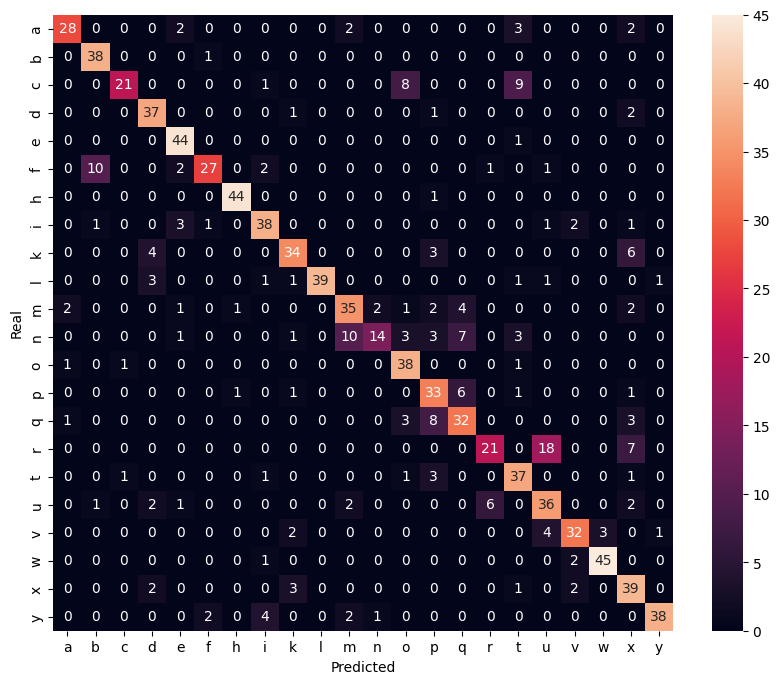

In [35]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

In [25]:
plt.tight_layout()
confusion_path = "../model/artifacts/confusion_matrix.png"
plt.savefig(confusion_path)
plt.close()

mlflow.log_artifact(confusion_path)

In [26]:
mlflow.end_run()

🏃 View run polite-shrike-512 at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0/runs/980a8d9789bb4a688ede103549d1e910
🧪 View experiment at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0
